In [1]:
import os
import warnings
import numpy as np

warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # shut up tensorflow debug messages

# Force use CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow.keras.models import load_model


def line2list(line):
    return line.strip().split(',')


def get_limits(feature, samples):
    """ Given a feature, get the minimal and maximal values """

    vals_this_feature = [sample[feature] for sample in samples.values()]

    return np.min(vals_this_feature), np.max(vals_this_feature)


def norm(val, low, high, new_low=0, new_high=1):
    """ Linearly scale a value from range <low, high> into
        a new range <new_low, new_high>
    """

    return (new_high - new_low) / (high - low) * (val - low) + new_low


def read_data(data_file):
    """ Read and normalize data
    returns: samples, targets (dicts keyed by a sample index)
    sample: dict keyed by a feature name
    target: binary value of {0, 1}
    """

    samples = {}
    targets = {}

    # Read data (encoding='utf-8-sig' => omit BOM)
    with open(data_file, 'r', encoding='utf-8-sig') as cfr:

        # Read feature names (CSV header), last col ~ target
        features = line2list(cfr.readline())[:-1]

        # Read samples and targets, add them to dicts (key ~ index)
        for ind, line in enumerate(cfr.readlines()):
            vals = line2list(line)

            # Feature vector representing a sample
            samples[ind] = {feature: float(val) for feature, val in zip(features, vals[:-1])}

            # Corresponding target
            targets[ind] = float(vals[-1])

    # Get limits and normalize samples

    for feature in features:
        low, high = get_limits(feature, samples)
        for sample in samples.values():
            sample[feature] = norm(sample[feature], low, high)

    return samples, targets, sorted(features)


def split_data(targets, split_ratio=(0.8, 0.1, 0.1), seed=1):
    """ Split data to disjunctive sets: train, dev, test
        return: dict
            keys: 'train', 'dev', 'test
            values: list of samples indices
    """

    split = {'train': [], 'dev': [], 'test': []}

    # Set random seed for shuffling this split
    np.random.seed(seed)

    ## Carefully and equally distribute positive and negative samples
    negs = [ind for ind, val in targets.items() if val == 0.0]
    poss = [ind for ind, val in targets.items() if val == 1.0]

    for kind in (negs, poss):
        np.random.shuffle(kind)
        for i, ind in enumerate(kind):
            if i / len(kind) < split_ratio[0]:
                split['train'].append(ind)
            elif split_ratio[0] < i / len(kind) < split_ratio[0] + split_ratio[1]:
                split['dev'].append(ind)
            else:
                split['test'].append(ind)

    return split


def form_data(samples, targets, split, feats):
    """ Prepare matrices for machine learning in Keras
        return dict with keys: 'x_train', 'y_train', 'x_dev', 'y_dev', 'x_test', 'y_test'
    """

    data = {}
    for group, inds in split.items():
        data['x_' + group] = np.array([[samples[ind][f] for f in feats] for ind in inds])
        data['y_' + group] = np.array([targets[ind] for ind in inds], ndmin=2).T

    return data


## Spusteni pro testovaci data nebo pro data cela

In [2]:
DATA_SPLIT_RATIO = (0.8, 0.1, 0.1)  # test data
# DATA_SPLIT_RATIO = (0, 0, 1)  # all data

In [ ]:
DATA_FILE = '../data/heart.csv'  # source CSV file

# Read and normalize data, sort features
samples, targets, feats = read_data(data_file=DATA_FILE)

# Split data (train, dev, test)
split = split_data(targets, DATA_SPLIT_RATIO, seed=19)

# Form data for Keras
data = form_data(samples, targets, split, feats)

best_model_path = '../models/best.h5'

## -- NEURAL NETWORK EVALUATION

# Load model for evaluation
evaluated_model = best_model_path
#evaluated_model = 'path_to_your_model_for_evaluation'

model = load_model(evaluated_model)

# Evaluate on test data
y_pred = model.predict(data['x_test'])

test_loss, test_acc = model.evaluate(data['x_test'], data['y_test'])

# for yi, ui in zip(y_pred, data['y_test']):
#     print(yi[0], ui[0])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 280
Traceback (most recent call last):
  File "/Users/kitt/miniconda3/envs/net/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-6f4073d77395>", line 20, in <module>
    model = load_model(evaluated_model)
  File "/Users/kitt/miniconda3/envs/net/lib/python3.7/site-packages/tensorflow_core/python/keras/saving/save.py", line 149, in load_model
    loader_impl.parse_saved_model(filepath)
  File "/Users/kitt/miniconda3/envs/net/lib/python3.7/site-packages/tensorflow_core/python/saved_model/loader_impl.py", line 83, in parse_saved_model
    constants.SAVED_MODEL_FILENAME_PB))
OSError: SavedModel file does not exist at: ../best_model/best.h5/{saved_model.pbtxt|saved_model.pb}

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

### Graf 1: ROC + AUC value

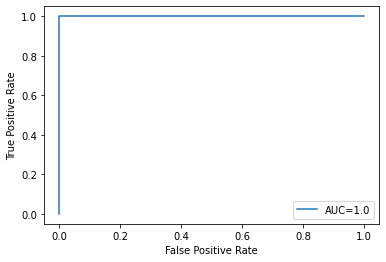

In [101]:
# knihovni metoda
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(data['y_test'], y_pred, pos_label=1, drop_intermediate=False)
auc = metrics.roc_auc_score(data['y_test'], y_pred)
# metrics.auc(fpr, tpr)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
def eval(u, y, th):
    tp, fp, tn, fn = 0, 0, 0, 0
    for ui, yi in zip(u, y):
        if ui >= th:
            if yi >= th:
                tp += 1
            else:
                fn += 1
        else:
            if yi >= th:
                fp += 1
            else:
                tn += 1
    
    return tp, fp, tn, fn

u = [ui[0] for ui in data['y_test']]
y = [yi[0] for yi in y_pred]

th_step = 0.01
ths = np.arange(th_step, 1, th_step)
fpr = []
tpr = []
for th in ths:
    tp, fp, tn, fn = eval(u, y, th)
    fpr.append(fp/(tn+fp))  # 1 - specificity
    tpr.append(tp/(tp+fn))  # recall
    #print(round(th, 4), 'acc:', round((tp+tn)/(tp+fp+tn+fn), 2), round(fpr[-1], 2), round(tpr[-1], 2))
    
#create ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

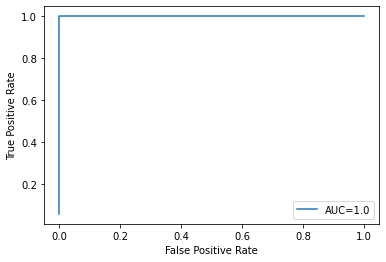

In [102]:
# implementace bez knihovny
y_true = np.array(data['y_test'].ravel())
y_score = np.array(y_pred.ravel())

# sort predicted scores in descending order
desc_score_indices = np.argsort(y_score)[::-1]
y_score = y_score[desc_score_indices]
y_true = y_true[desc_score_indices]

# y_score typically consists of tied values. Here we extract
# the indices associated with the distinct values.
distinct_indices = np.where(np.diff(y_score))[0]
threshold_indices = np.append(distinct_indices, (y_true.size - 1))

thresholds = y_score[threshold_indices]
tps = np.cumsum(y_true)[threshold_indices]

# (1 + threshold_indices) = the number of positives at each index, thus number of data points minus true
# positives = false positives
fps = (1 + threshold_indices) - tps
tpr = tps / tps[-1]
fpr = fps / fps[-1]

# compute AUC using the trapezoidal rule;
# appending an extra 0 is just to ensure the length matches

tpr_diff = np.append(np.diff(tpr), 0)
fpr_diff = np.append(np.diff(fpr), 0)
auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Graf 2: osa X: threshold, osa Y:
- TP
- FP
- TN
- FN

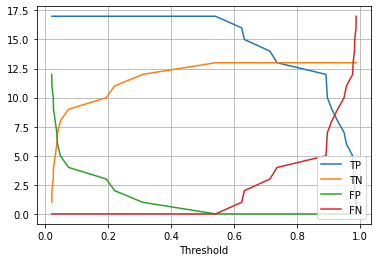

In [103]:
# knihovni metoda
from sklearn.metrics import confusion_matrix

tp = []
tn = []
fp = []
fn = []
for threshold in thresholds:
    y_round = []
    for yi, ui in zip(y_pred, data['y_test']):
        y_round.append(1 if (yi[0] > threshold) else 0)

    TN, FP, FN, TP = confusion_matrix(data['y_test'], y_round).ravel()
    tp.append(TP)
    tn.append(TN)
    fp.append(FP)
    fn.append(FN)

plt.plot(thresholds, tp, label='TP')
plt.plot(thresholds, tn, label='TN')
plt.plot(thresholds, fp, label='FP')
plt.plot(thresholds, fn, label='FN')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()

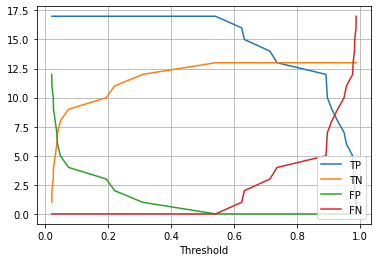

In [104]:
# implemenatace bez knihovny
def TP_TN_FP_FN(y_actual, y_pred, threshold):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for yi, ui in zip(y_pred, y_actual):
        y_round = 1 if (yi[0] > threshold) else 0
        if ui == y_round == 1:
            TP += 1
        if ui == y_round == 0:
            TN += 1
        if y_round == 1 and ui == 0:
            FP += 1
        if y_round == 0 and ui == 1:
            FN += 1

    return (TP, TN, FP, FN)


tp = []
tn = []
fp = []
fn = []
for threshold in thresholds:
    TP, TN, FP, FN = TP_TN_FP_FN(data['y_test'], y_pred, threshold)
    tp.append(TP)
    tn.append(TN)
    fp.append(FP)
    fn.append(FN)

plt.plot(thresholds, tp, label='TP')
plt.plot(thresholds, tn, label='TN')
plt.plot(thresholds, fp, label='FP')
plt.plot(thresholds, fn, label='FN')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()

### Confusion matrix pro threshold 0.5

In [105]:
threshold = 0.5

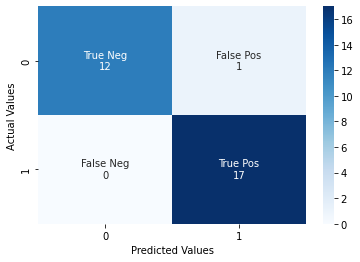

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

y_round = []
for yi, ui in zip(y_pred, data['y_test']):
    y_round.append(1 if (yi[0] > threshold) else 0)
TN, FP, FN, TP = confusion_matrix(data['y_test'], y_round).ravel()
labels = ['True Neg\n{}'.format(TN), 'False Pos\n{}'.format(FP), 'False Neg\n{}'.format(FN), 'True Pos\n{}'.format(TP)]

labels = np.asarray(labels).reshape(2, 2)
cf_matrix = confusion_matrix(data['y_test'], y_round)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

plt.show()

In [107]:
# hodnoty ziskane neknihovni metodou
TP, TN, FP, FN = TP_TN_FP_FN(data['y_test'], y_pred, threshold)
print('TN: {}'.format(TN))
print('FP: {}'.format(FP))
print('FN: {}'.format(FN))
print('TP: {}'.format(TP))

TN: 12
FP: 1
FN: 0
TP: 17


### Graf 3: osa X: treshold, osa Y:
- Accuracy
- Precision
- Recall

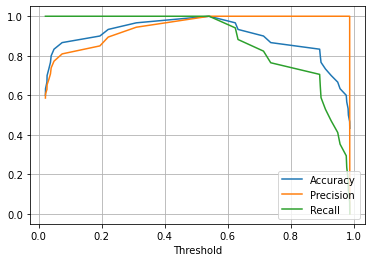

In [108]:
# knihovni metoda
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracies = []
precisions = []
recalls = []

for threshold in thresholds:
    y_round = []
    for yi, ui in zip(y_pred, data['y_test']):
        y_round.append(1 if (yi[0] > threshold) else 0)
    accuracies.append(accuracy_score(data['y_test'], y_round))
    precisions.append(precision_score(data['y_test'], y_round))
    recalls.append(recall_score(data['y_test'], y_round))

plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()

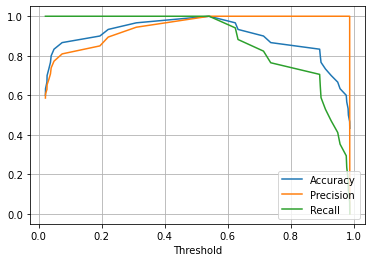

In [109]:
# implemenatace bez knihovny

accuracies = []
precisions = []
recalls = []

for threshold in thresholds:
    TP, TN, FP, FN = TP_TN_FP_FN(data['y_test'], y_pred, threshold)
    accuracies.append((TP + TN) / (TP + TN + FP + FN))
    precisions.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
    recalls.append(TP / (TP + FN))

plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()

### Graf 4: osa X: treshold, osa Y:
- F1 score
- Specificity
- Negative Predictive Value

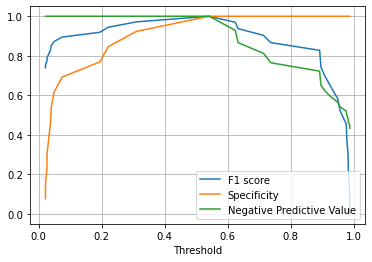

In [110]:
# knihovni metoda
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

f1_scores = []
specificities = []
negative_predictive_values = []

for threshold in thresholds:
    y_round = []
    for yi, ui in zip(y_pred, data['y_test']):
        y_round.append(1 if (yi[0] > threshold) else 0)
    f1_scores.append(f1_score(data['y_test'], y_round))
    TN, FP, FN, TP = confusion_matrix(data['y_test'], y_round).ravel()
    specificities.append(TN / (TN + FP))
    negative_predictive_values.append(TN / (TN + FN))

plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, specificities, label='Specificity')
plt.plot(thresholds, negative_predictive_values, label='Negative Predictive Value')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()

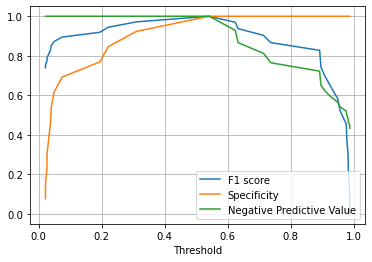

In [111]:
# implemenatace bez knihovny

f1_scores = []
specificities = []
negative_predictive_values = []

for threshold in thresholds:
    TP, TN, FP, FN = TP_TN_FP_FN(data['y_test'], y_pred, threshold)
    f1_scores.append(2 * TP / ((2 * TP) + FP + FN))
    specificities.append(TN / (TN + FP))
    negative_predictive_values.append(TN / (TN + FN))

plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, specificities, label='Specificity')
plt.plot(thresholds, negative_predictive_values, label='Negative Predictive Value')
plt.xlabel('Threshold')
plt.legend(loc=4)
plt.grid()
plt.show()